# Check available GPUs
----

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

# Import necessary modules
---

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import pandas as pd
import numpy as np 
from glob import glob 
import os
from imread import imread 
from sklearn.model_selection import train_test_split
import shutil
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D,GlobalMaxPooling2D, Flatten, Concatenate
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix

# Create folder structure and label images
---

The original dataset from the kaggle challange comes as a zip-folder, containing all image data as well as a csv-file with the corresponding labels. From the original data a dataframe is created and data is splitted in training/testing (80/20) and then in training/validation (80/20). Data is then stored in labeled folder for further processing and the possibility to delete original zipped data.

In [3]:
img_data = 'data/'
labels_data = 'labels/'
model_data = 'model_data/'

train = model_data + 'train'
valid = model_data + 'valid'
test = model_data + 'test'

# create dataframe with all .tif-data and 'path'-column
df = pd.DataFrame({'path': glob(os.path.join(img_data,'*.tif'))})
# create id from filepath
df['id'] = df.path.map(lambda x: x.split('/')[1].split('.')[0])
#create dataframe for labels with id
labels = pd.read_csv(labels_data + 'histopathology_labels.csv')
#merge dataframes and match labels
df = df.merge(labels, on='id')
#read tiff-files and convert to (96, 96, 3)-arrays in column 'image'
df['image'] = df['path'].map(imread)

df.head()

,path,id,label,image
0,data/5ee48c6b3a7d795732b0f7d426a7dc660cd76f44.tif,5ee48c6b3a7d795732b0f7d426a7dc660cd76f44,0,"[[[225, 227, 222], [244, 246, 241], [238, 240,..."
1,data/0fae2da51c638d47780e00522087667dce2eea49.tif,0fae2da51c638d47780e00522087667dce2eea49,1,"[[[164, 127, 144], [141, 102, 120], [241, 200,..."
2,data/2cce7af8067e40dca9182f6af36e098831df2fd9.tif,2cce7af8067e40dca9182f6af36e098831df2fd9,1,"[[[180, 121, 213], [141, 85, 172], [184, 130, ..."
3,data/522a67df1bdf1060ab6df768b93f9a0311471310.tif,522a67df1bdf1060ab6df768b93f9a0311471310,0,"[[[198, 121, 203], [162, 85, 165], [147, 70, 1..."
4,data/9e2734ab0b4eae8e19f6e46323cde13c090abca1.tif,9e2734ab0b4eae8e19f6e46323cde13c090abca1,0,"[[[244, 227, 233], [244, 227, 233], [244, 227,..."


In [4]:
df['image'][0].shape

(96, 96, 3)

In [5]:
df.shape

(220025, 4)

In [6]:
# create folder structure for train, valid, test
for folder in [train, valid, test]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)
        

#create train, test split 80/20 and train, validation split 80/20
train_df, test_df = train_test_split(df, train_size=0.8, stratify=df['label'])
train_df, valid_df = train_test_split(train_df, train_size=0.8, stratify=train_df['label'])

print("Dataframes sucessfully created: train_df: {}, valid_df: {}, test_df: {}".format(train_df.shape,valid_df.shape,test_df.shape))        

Dataframes sucessfully created: train_df: (140816, 4), valid_df: (35204, 4), test_df: (44005, 4)


In [7]:
#set id as index for df
df.set_index('id', inplace=True)

#create new folder structure for train, validation and testing and sort due to labels
for tup in [(train_df, train), (valid_df, valid), (test_df, test)]:
    images = tup[0]
    path = tup[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(df.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(img_data, file_name)
            shutil.copyfile(source, destination)

# Data distribution and sample illustration
---


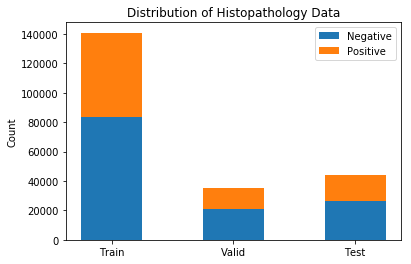

There are 140816 training files:
- labeled positive: 57035
- labeled negative: 83781

There are 35204 validation files:
- labeled positive: 14259
- labeled negative: 20945

There are 44005 test files:
- labeled positive: 17823
- labeled negative: 26182


In [4]:
# Illustrate distribution of labeled data

train_0 = len(os.listdir('model_data/train/0'))
train_1 = len(os.listdir('model_data/train/1'))
valid_0 = len(os.listdir('model_data/valid/0'))
valid_1 = len(os.listdir('model_data/valid/1'))
test_0 = len(os.listdir('model_data/test/0'))
test_1 = len(os.listdir('model_data/test/1'))

N = 3
label_0 = (train_0, valid_0, test_0)
label_1 = (train_1, valid_1, test_1)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, label_0, width)
p2 = plt.bar(ind, label_1, width, bottom=label_0)

plt.ylabel('Count')
plt.title('Distribution of Histopathology Data')
plt.xticks(ind, ('Train', 'Valid', 'Test'))
plt.yticks(np.arange(0, 150000, 20000))
plt.legend((p1[0], p2[0]), ('Negative', 'Positive'))

plt.show()
print('There are {} training files:\n- labeled positive: {}\n- labeled negative: {}'.format(train_0+train_1,train_1,train_0))
print('\nThere are {} validation files:\n- labeled positive: {}\n- labeled negative: {}'.format(valid_0+valid_1,valid_1,valid_0))
print('\nThere are {} test files:\n- labeled positive: {}\n- labeled negative: {}'.format(test_0+test_1,test_1,test_0))



In [4]:
examples_0 = ['model_data/train/0/'+e for e in os.listdir('model_data/train/0')[:8]]
examples_1 = ['model_data/train/1/'+e for e in os.listdir('model_data/train/1')[:8]]

In [5]:
def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(25,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('on')

Example images of train folder labeled no cancer (0):


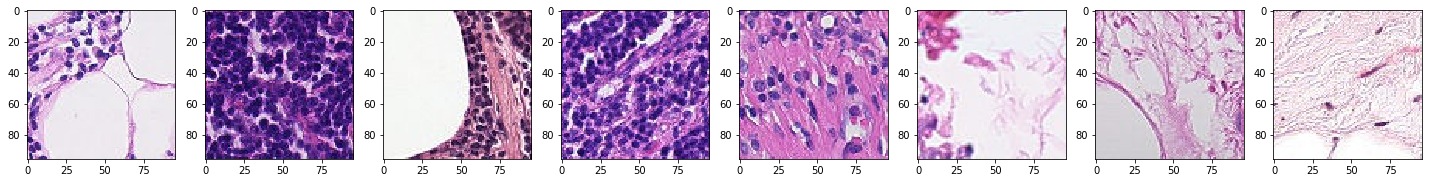

In [6]:
print('Example images of train folder labeled no cancer (0):')
showImagesHorizontally(examples_0)

Example images of train folder labeled cancer (1):


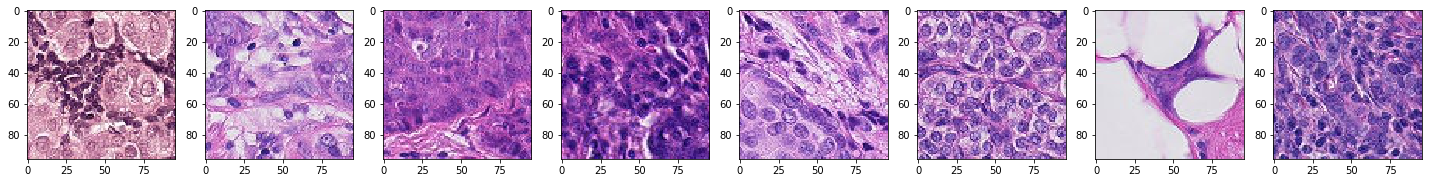

In [7]:
print('Example images of train folder labeled cancer (1):')
showImagesHorizontally(examples_1)

# Data augmentation
---


In [5]:
#Instanciate keras image data generator for augmentation of training data

RESCALE=1./255
FLIP_H=True
FLIP_V=True
RANGE_ROTATION=180
RANGE_ZOOM=0.4
RANGE_SHIFT_WIDTH=0.3
RANGE_SHIFT_HEIGHT=0.3
RANGE_SHIFT_CHANNEL=0.3
RANGE_SHEAR=0.3

train_datagenerator = ImageDataGenerator(rescale=RESCALE,
                                         featurewise_center=False, 
                                         samplewise_center=False, 
                                         featurewise_std_normalization=False, 
                                         samplewise_std_normalization=False, 
                                         zca_whitening=False, 
                                         rotation_range=RANGE_ROTATION, 
                                         width_shift_range=RANGE_SHIFT_WIDTH, 
                                         height_shift_range=RANGE_SHIFT_HEIGHT, 
                                         shear_range=RANGE_SHEAR, 
                                         zoom_range=RANGE_ZOOM, 
                                         channel_shift_range=RANGE_SHIFT_CHANNEL, 
                                         horizontal_flip=FLIP_H, 
                                         vertical_flip=FLIP_V)

# Prepare data generators and edit parameters
---

In [6]:
from utils import build_data_generators

pre_trained_model = NASNetMobile
LR = 0.0001
DECAY = 0.00001
LOSS = 'binary_crossentropy'
IMAGE_SIZE=96
BATCH_SIZE=200
OUTPUT_DIRECTORY = 'output/training/'
MODEL_FILE = OUTPUT_DIRECTORY + 'checkpoint/weights.best.model_NASNetmobile_full.h5'
TRAINING_LOGS_FILE = OUTPUT_DIRECTORY + 'logs/training_logs.csv'
MODEL_PLOT_FILE = OUTPUT_DIRECTORY + 'model_NASNetmobile_full.png'

MC = ModelCheckpoint(filepath=MODEL_FILE, verbose=1, save_best_only=True)
CSVL = CSVLogger(TRAINING_LOGS_FILE, append=False, separator=';')

datagen_train, datagen_valid, datagen_test = build_data_generators(IMAGE_SIZE, BATCH_SIZE, RESCALE, ImageDataGenerator, train_datagenerator)

Found 140816 images belonging to 2 classes.
Found 35204 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


# Building pre-trained model
---

In [8]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

#no pre-trained weights are used, since dataset is very large
base_model = pre_trained_model(include_top=False, input_shape=input_shape, weights=None)

x = base_model(inputs)

GMP = GlobalMaxPooling2D()(x)
GAP = GlobalAveragePooling2D()(x)
FL = Flatten()(x)

outputs = Concatenate(axis=-1)([GMP,GAP,FL])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
    
model.compile(optimizer=Adam(lr=LR, decay=DECAY), loss=LOSS, metrics=['acc'])

plot_model(model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_poolin

---
# 1st 20 Training epocs
---

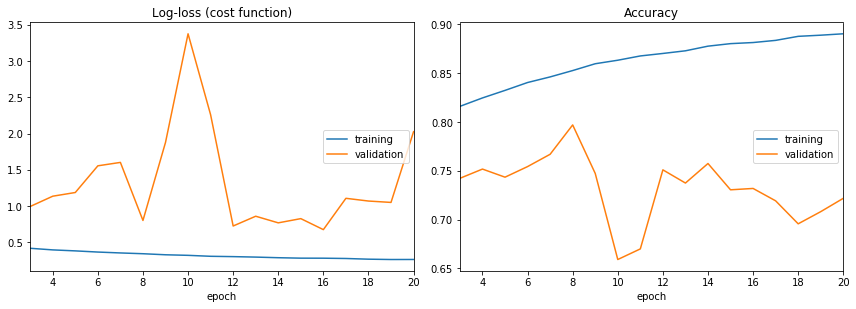

Log-loss (cost function):
training   (min:    0.264, max:    0.507, cur:    0.264)
validation (min:    0.676, max:    3.374, cur:    2.025)

Accuracy:
training   (min:    0.777, max:    0.890, cur:    0.890)
validation (min:    0.637, max:    0.797, cur:    0.722)

Epoch 00020: val_loss did not improve from 0.67566


In [20]:
# Training of first 20 epocs of NASNetmobile_full 
history = model.fit_generator(datagen_train,
                              steps_per_epoch=len(datagen_train), 
                              validation_data=datagen_valid,
                              validation_steps=len(datagen_valid),
                              epochs=20,
                              verbose=1,
                              callbacks=[PlotLossesKeras(),MC,CSVL])

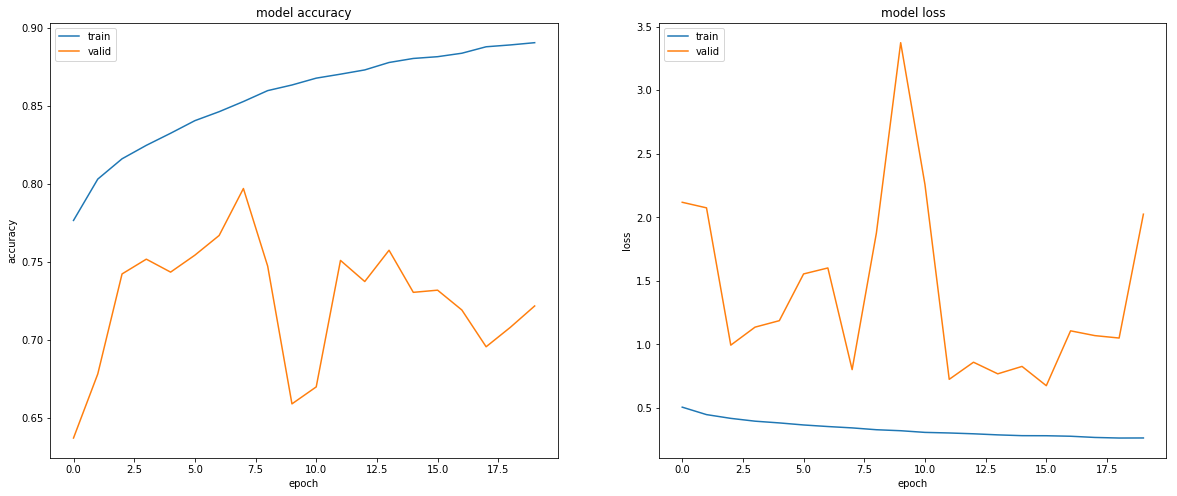

In [21]:
#Plot accuracy and model loss during training of first 20 epocs
fig = figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

---
# 2nd Training period - 10 epocs
---

In [12]:
model.load_weights('output/training/checkpoint/weights.best.model_NASNetmobile_full_first_20_episodes.h5')

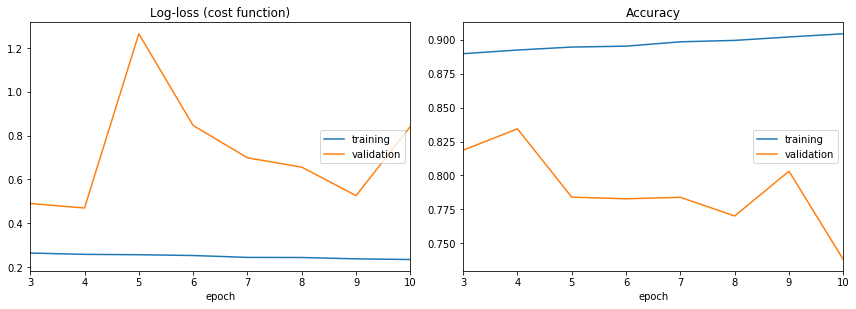

Log-loss (cost function):
training   (min:    0.234, max:    0.275, cur:    0.234)
validation (min:    0.391, max:    1.264, cur:    0.841)

Accuracy:
training   (min:    0.885, max:    0.904, cur:    0.904)
validation (min:    0.738, max:    0.838, cur:    0.738)

Epoch 00010: val_loss did not improve from 0.39081


In [13]:
# Training of 10 epocs of NASNetmobile_full, based on first 20 training epocs 
#(reverted from checkpoint with best validation loss)
history = model.fit_generator(datagen_train,
                              steps_per_epoch=len(datagen_train), 
                              validation_data=datagen_valid,
                              validation_steps=len(datagen_valid),
                              epochs=10,
                              verbose=1,
                              callbacks=[PlotLossesKeras(),MC,CSVL])

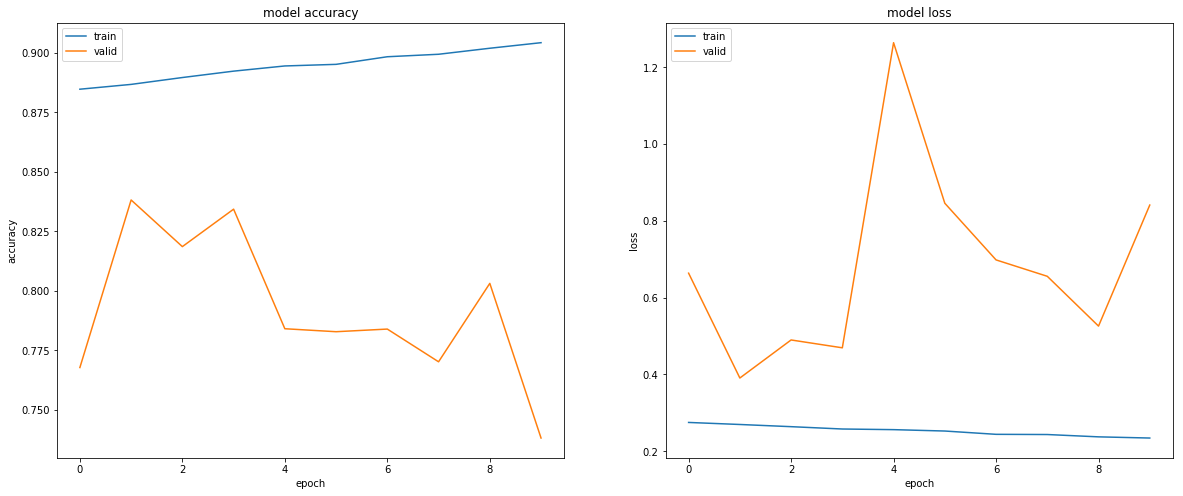

In [14]:
#Plot accuracy and model loss during training of epocs 21-30
fig = figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

---
# 3rd Training period - 10 epocs
---

In [8]:
model.load_weights('output/training/checkpoint/weights.best.model_NASNetmobile_full_first_30_episodes.h5')

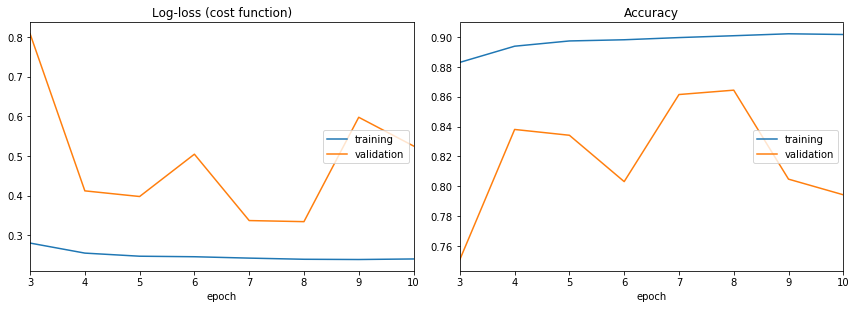

Log-loss (cost function):
training   (min:    0.239, max:    0.281, cur:    0.241)
validation (min:    0.335, max:    0.808, cur:    0.525)

Accuracy:
training   (min:    0.883, max:    0.902, cur:    0.902)
validation (min:    0.751, max:    0.864, cur:    0.794)

Epoch 00010: val_loss did not improve from 0.33467


In [9]:
# Training of 10 epocs of NASNetmobile_full, based on first 30 training epocs 
#(reverted from checkpoint with best validation loss)
history = model.fit_generator(datagen_train,
                              steps_per_epoch=len(datagen_train), 
                              validation_data=datagen_valid,
                              validation_steps=len(datagen_valid),
                              epochs=10,
                              verbose=1,
                              callbacks=[PlotLossesKeras(),MC,CSVL])

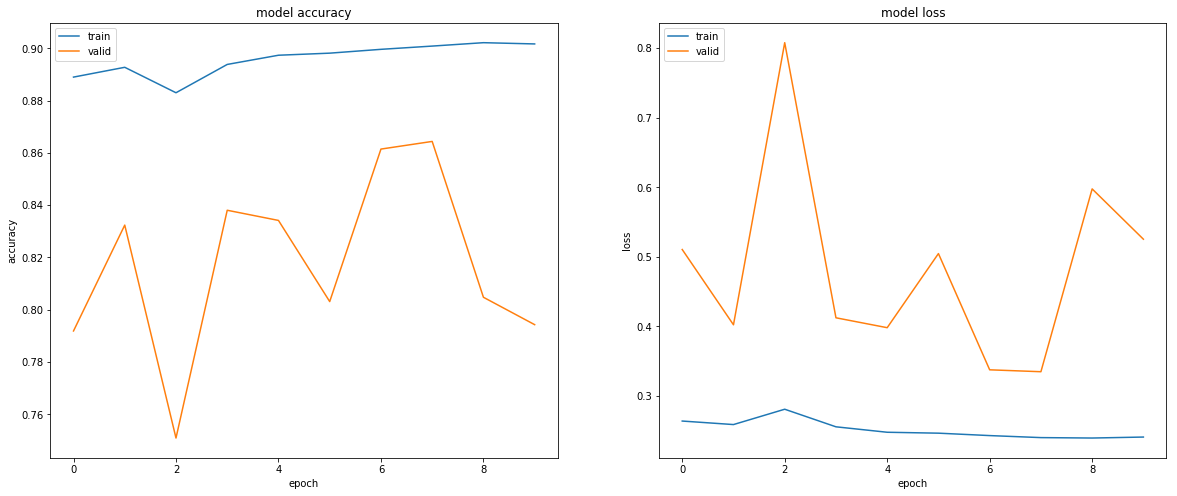

In [10]:
#Plot accuracy and model loss during training of epocs 31-40
fig = figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

# Create dataframe with normalized image tensors of test dataset
---

In [3]:
from utils import create_df_test
#create dataframe with normalized test image arrays and lables
df_test = create_df_test('model_data/test/0','model_data/test/1')

# Use model to make predictions on test data
---

In [10]:
#load trained model weights
model.load_weights(MODEL_FILE)

#make predictions to new column
def make_prediction(array):
    return model.predict(array)

df_test['model_prediction'] = df_test['image_tensor'].apply(make_prediction)

#drop unneeded column
df_test.drop(labels=['image_tensor'], axis=1, inplace=True)

In [11]:
#store dataframe as pickle-file
df_test.to_pickle('output/dataframes/test_data_lables_and_prediction_NASNetmobile_full.pkl')

In [3]:
#read pickle file and restore dataframe
df_classification = pd.read_pickle('output/dataframes/test_data_lables_and_prediction_NASNetmobile_full.pkl')

In [4]:
from utils import model_prediction_binary
#convert prediction to binary prediction label (default treshold = 0.5)
df_classification['binary_model_prediction'] = df_classification['model_prediction'].apply(model_prediction_binary)

In [5]:
#translate prediction value from nested array to float
def value_translation(x):
    return x[0][0]
df_classification['model_prediction_value'] = df_classification['model_prediction'].apply(value_translation)

In [6]:
#drop unneeded column
df_classification.drop(labels=['model_prediction'], axis=1, inplace=True)

In [7]:
df_classification.head()

,path,id,label,binary_model_prediction,model_prediction_value
0,model_data/test/0/9fd149ad9fdb180e5e266bd7464c...,9fd149ad9fdb180e5e266bd7464c0bea3cc4bbdf,0,0,0.278665
1,model_data/test/0/4f8727d0beb95633f6f228d10576...,4f8727d0beb95633f6f228d105767a0307150b9c,0,0,0.005880
2,model_data/test/0/d48b8d6a8be797fe1fcc9a2a1e84...,d48b8d6a8be797fe1fcc9a2a1e84c441a6777ad2,0,0,0.000566
3,model_data/test/0/a4c266bec6608661a3ad08103c9a...,a4c266bec6608661a3ad08103c9a91b922e29d36,0,0,0.097175
4,model_data/test/0/afc0f1d024bdceb12ee2420d1d19...,afc0f1d024bdceb12ee2420d1d19a8bae5f39042,0,0,0.012870


# Evaluation metrics
---

In [8]:
#get confusion matrix
confusion_matrix = pd.crosstab(df_classification['label'], df_classification['binary_model_prediction'], rownames=['Label'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      0      1
Label                  
0          23622   2560
1           3376  14447


In [41]:
#get evaluation metrics
TN = confusion_matrix[0][0]
FN = confusion_matrix[0][1]
FP = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
TPR = TP/(TP+FN)
sensitivity = TPR
specitivity = TNR

print('Model prediction metrics (threshold=0.5):\n\nSensitivity: {:.2f}%\nSpecitivity: {:.2f}%\nFalse Posisitive Rate: {:.2f}%'.format(sensitivity*100,specitivity*100,FPR*100))

Model prediction metrics (threshold=0.5):

Sensitivity: 81.06%
Specitivity: 90.22%
False Posisitive Rate: 9.78%


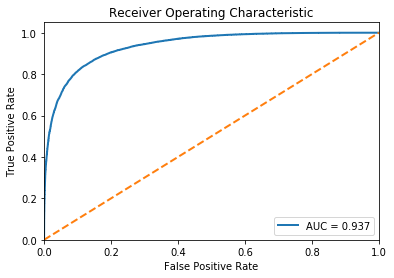

In [43]:
#get ROC curve and AUC value
false_positive_rate, true_positive_rate, threshold = roc_curve(df_classification['label'], df_classification['model_prediction_value'])
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve), lw=lw)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Xception
---

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

#no pre-trained weights are used, since dataset is very large
base_model = Xception(include_top=False, input_shape=input_shape, weights=None)

x = base_model(inputs)

x = GlobalAveragePooling2D()(x)

outputs = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
    
model.compile(optimizer=Adam(lr=LR, decay=DECAY), loss=LOSS, metrics=['acc'])

plot_model(model, to_file='output/training/model_Xception.png', show_shapes=True, show_layer_names=True)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


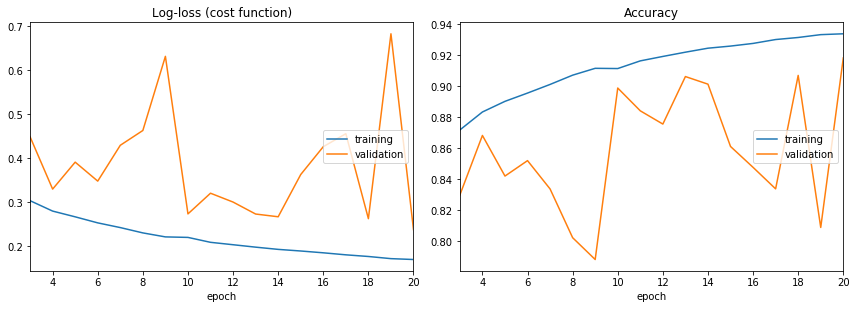

Log-loss (cost function):
training   (min:    0.169, max:    0.392, cur:    0.169)
validation (min:    0.237, max:    0.682, cur:    0.237)

Accuracy:
training   (min:    0.827, max:    0.934, cur:    0.934)
validation (min:    0.788, max:    0.918, cur:    0.918)

Epoch 00020: val_loss improved from 0.26209 to 0.23723, saving model to output/training/checkpoint/weights.best.model_NASNetmobile_full.h5


In [49]:
MODEL_FILE = OUTPUT_DIRECTORY + 'checkpoint/weights.best.model_Xception_full.h5'
TRAINING_LOGS_FILE = OUTPUT_DIRECTORY + 'logs/Xception_training_logs.csv'

history = model.fit_generator(datagen_train,
                              steps_per_epoch=len(datagen_train), 
                              validation_data=datagen_valid,
                              validation_steps=len(datagen_valid),
                              epochs=20,
                              verbose=1,
                              callbacks=[PlotLossesKeras(),MC,CSVL])

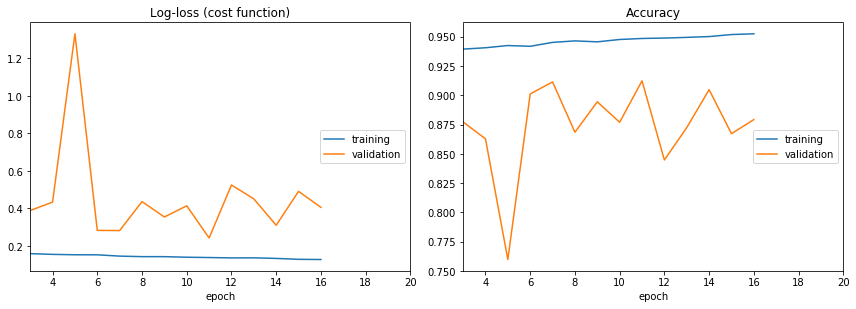

Log-loss (cost function):
training   (min:    0.127, max:    0.164, cur:    0.127)
validation (min:    0.242, max:    1.332, cur:    0.405)

Accuracy:
training   (min:    0.937, max:    0.952, cur:    0.952)
validation (min:    0.760, max:    0.912, cur:    0.879)

Epoch 00016: val_loss did not improve from 0.23723
Epoch 17/20
 78/705 [==>...........................] - ETA: 14:48 - loss: 0.1232 - acc: 0.9542

In [ ]:
MODEL_FILE = OUTPUT_DIRECTORY + 'checkpoint/weights.best.model_Xception_full_20.h5'
TRAINING_LOGS_FILE = OUTPUT_DIRECTORY + 'logs/Xception_training_logs_20.csv'

history = model.fit_generator(datagen_train,
                              steps_per_epoch=len(datagen_train), 
                              validation_data=datagen_valid,
                              validation_steps=len(datagen_valid),
                              epochs=20,
                              verbose=1,
                              callbacks=[PlotLossesKeras(),MC,CSVL])

In [11]:
MODEL_FILE = OUTPUT_DIRECTORY + 'checkpoint/weights.best.model_Xception_full.h5'

# Xception - Create dataframe with normalized image tensors of test dataset
---

In [13]:
from utils import create_df_test
#create dataframe with normalized test image arrays and lables
df_test = create_df_test('model_data/test/0','model_data/test/1')

# Xception - Use model to make predictions on test data
---

In [14]:
#load trained model weights
model.load_weights(MODEL_FILE)

#make predictions to new column
def make_prediction(array):
    return model.predict(array)

df_test['model_prediction'] = df_test['image_tensor'].apply(make_prediction)

#drop unneeded column
df_test.drop(labels=['image_tensor'], axis=1, inplace=True)

In [15]:
#store dataframe as pickle-file
df_test.to_pickle('output/dataframes/test_data_lables_and_prediction_Xception_full.pkl')

In [16]:
#read pickle file and restore dataframe
df_classification = pd.read_pickle('output/dataframes/test_data_lables_and_prediction_Xception_full.pkl')

In [17]:
from utils import model_prediction_binary
#convert prediction to binary prediction label (default treshold = 0.5)
df_classification['binary_model_prediction'] = df_classification['model_prediction'].apply(model_prediction_binary)

In [18]:
#translate prediction value from nested array to float
def value_translation(x):
    return x[0][0]
df_classification['model_prediction_value'] = df_classification['model_prediction'].apply(value_translation)

In [19]:
#drop unneeded column
df_classification.drop(labels=['model_prediction'], axis=1, inplace=True)

In [20]:
df_classification.head()

,path,id,label,binary_model_prediction,model_prediction_value
0,model_data/test/0/9fd149ad9fdb180e5e266bd7464c...,9fd149ad9fdb180e5e266bd7464c0bea3cc4bbdf,0,0,0.003023
1,model_data/test/0/4f8727d0beb95633f6f228d10576...,4f8727d0beb95633f6f228d105767a0307150b9c,0,0,0.000899
2,model_data/test/0/d48b8d6a8be797fe1fcc9a2a1e84...,d48b8d6a8be797fe1fcc9a2a1e84c441a6777ad2,0,0,0.000384
3,model_data/test/0/a4c266bec6608661a3ad08103c9a...,a4c266bec6608661a3ad08103c9a91b922e29d36,0,0,0.000284
4,model_data/test/0/afc0f1d024bdceb12ee2420d1d19...,afc0f1d024bdceb12ee2420d1d19a8bae5f39042,0,0,0.000758


# Xception - Evaluation metrics
---

In [21]:
#get confusion matrix
confusion_matrix = pd.crosstab(df_classification['label'], df_classification['binary_model_prediction'], rownames=['Label'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      0      1
Label                  
0          25600    582
1           2989  14834


In [22]:
#get evaluation metrics
TN = confusion_matrix[0][0]
FN = confusion_matrix[0][1]
FP = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
TPR = TP/(TP+FN)
sensitivity = TPR
specitivity = TNR

print('Model prediction metrics (threshold=0.5):\n\nSensitivity: {:.2f}%\nSpecitivity: {:.2f}%\nFalse Posisitive Rate: {:.2f}%'.format(sensitivity*100,specitivity*100,FPR*100))

Model prediction metrics (threshold=0.5):

Sensitivity: 83.23%
Specitivity: 97.78%
False Posisitive Rate: 2.22%


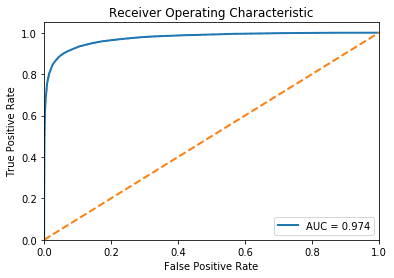

In [23]:
#get ROC curve and AUC value
false_positive_rate, true_positive_rate, threshold = roc_curve(df_classification['label'], df_classification['model_prediction_value'])
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve), lw=lw)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()